In [36]:
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPool1D, Embedding
from keras.models import Model

In [2]:
max_sequence_length = 100
max_vocab_size = 20000
embedding_dim = 100
validation_split = 0.2
batch_size = 128
epochs = 10

In [5]:
#  load the pre-trained glove vectors
word2vec = {}
f = open('glove.6B/glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print(len(word2vec))

400000


In [8]:
train = pd.read_csv("kaggle_toxic/train.csv")
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
# read in the training data
sentences = train["comment_text"].fillna("DUMMY_VAL").values
# here we get the 0/1 value for each label in the dataset (do all of them at once) for all rows
possible_labels = ['toxic', 'severe_toxic','obscene','threat','insult','identity_hate']
targets = train[possible_labels].values

In [12]:
print(max(len(s) for s in sentences))
print(min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print(s[len(s) // 2])

5000
6
205


In [18]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [19]:
word2index = tokenizer.word_index
print(len(word2index))

210337


In [20]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
print(data.shape)

(159571, 100)


In [23]:
num_words = min(max_vocab_size, len(word2index)+1)
print(num_words)

20000


In [24]:
# load the embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

for word,i in  word2index.items():
    if i < max_vocab_size:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
         # words not in the glove will be set to zero   
            embedding_matrix[i] = embedding_vector

In [29]:
embedding_layer = Embedding(
num_words,
embedding_dim,
weights = [embedding_matrix],
input_length=max_sequence_length,
trainable=False )# we set trainable to false so the weights will stay same during training
    
input_ = Input(shape=(max_sequence_length, ))
x = embedding_layer(input_)
# keras.layers.Conv1D(filters, kernel_size, activation)
# filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window (size of the filter))
x = Conv1D(128, 3, activation='relu')(x)
# MaxPooling1D(pool_size=2)
# 3 heres means the featuremap will downsize the input by 3 times
x = MaxPool1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
# in here we are doing 6 different binary classification for each item in our dataset
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 128)            49280     
__________

MaxPool1D vs GlobalMaxPooling1D<br>
normal maxpool searches for features by step size (same size as the filter window)<br>
MaxPool1D output = 3D tensor with shape: (batch_size, steps, features)<br>
in global maxpool there is no window we get features from the whole input,that is why <br>
there is no pool_size in here<br>
GlobalMaxPooling1D output = 2D tensor with shape: (batch_size, features)<br>

In [30]:
r = model.fit(data, targets, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 25s 197us/step - loss: 0.0831 - acc: 0.9733 - val_loss: 0.0739 - val_acc: 0.9758
Epoch 2/10
127656/127656 [==============================] - 21s 168us/step - loss: 0.0670 - acc: 0.9774 - val_loss: 0.0686 - val_acc: 0.9760
Epoch 3/10
127656/127656 [==============================] - 21s 165us/step - loss: 0.0625 - acc: 0.9786 - val_loss: 0.0699 - val_acc: 0.9762
Epoch 4/10
127656/127656 [==============================] - 21s 166us/step - loss: 0.0596 - acc: 0.9794 - val_loss: 0.0681 - val_acc: 0.9779
Epoch 5/10
127656/127656 [==============================] - 21s 161us/step - loss: 0.0573 - acc: 0.9800 - val_loss: 0.0809 - val_acc: 0.9767
Epoch 6/10
127656/127656 [==============================] - 21s 162us/step - loss: 0.0551 - acc: 0.9806 - val_loss: 0.0868 - val_acc: 0.9764
Epoch 7/10
127656/127656 [==============================] - 21s 161us/step - loss: 0.0536 - acc: 0.9810

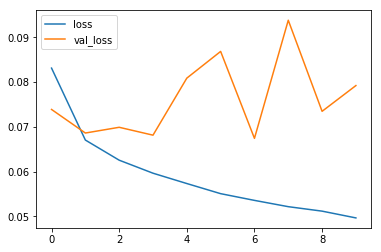

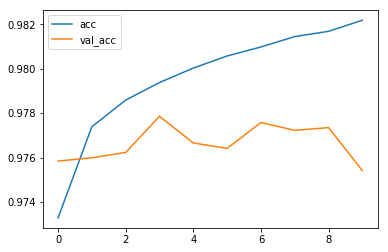

In [33]:
# plot the results
plt.plot(r.history['loss'], label='loss')#
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')#
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()